In [1]:
from numpy import genfromtxt

bands = genfromtxt('./helpers/bands.csv', delimiter=',')

In [2]:
leaf_pixel_x = 25
leaf_pixel_y = 25
start_band = 110
end_band = 135
band_delta = end_band - start_band
band_range = bands[start_band:end_band]

In [3]:
import numpy as np
import matplotlib.pyplot as plt

rois_old = np.empty((6, 50, 50, band_delta))
for i in range(1, 4):
    current_rois = np.load("rois_old{}.npy".format(i))
    current_rois = current_rois[..., start_band:end_band]
    rois_old = np.append(rois_old, current_rois, axis=0)

rois_old = np.delete(rois_old, np.s_[0:6], axis=0)
rois_old.shape

(18, 50, 50, 25)

In [4]:
rois_young = np.empty((6, 50, 50, band_delta))
for i in range(1, 4):
    current_rois = np.load("rois_young{}.npy".format(i))
    current_rois = current_rois[..., start_band:end_band]
    rois_young = np.append(rois_young, current_rois, axis=0)

rois_young = np.delete(rois_young, np.s_[0:6], axis=0)
rois_young.shape

(18, 50, 50, 25)

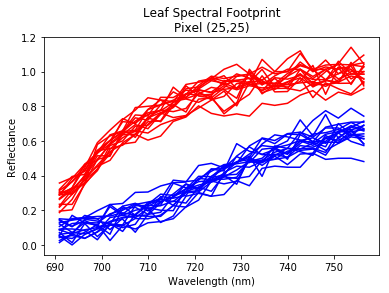

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111)

for i in range(1, rois_young.shape[0]):
    leaf_pixel = rois_old[i, leaf_pixel_x, leaf_pixel_y, :]
    leaf_pixel_squeezed = np.squeeze(leaf_pixel)
    ax.plot(band_range, leaf_pixel_squeezed, 'b')
    
    leaf_pixel = rois_young[i, leaf_pixel_x, leaf_pixel_y, :]
    leaf_pixel_squeezed = np.squeeze(leaf_pixel)
    ax.plot(band_range, leaf_pixel_squeezed ,'r')

plt.title('Leaf Spectral Footprint\nPixel ({},{})'.format(
    leaf_pixel_x, leaf_pixel_y))
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance')
plt.show([-100, 100])

((18, 50, 50, 25), (18, 50, 25, 50))


ImageView object:
  Display bands       :  (25, 25, 25)
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.19480518996715546, 1.0129870176315308]
    G: [0.19480518996715546, 1.0129870176315308]
    B: [0.19480518996715546, 1.0129870176315308]

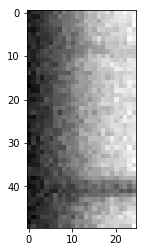

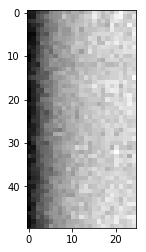

In [6]:
from spectral import imshow 
    
# (n x H x W x D) to (n x W x D x H) 
rois_old_rot = np.transpose(rois_old, (0, 2, 3, 1))
rois_young_rot = np.transpose(rois_young, (0, 2, 3, 1))

print((rois_old.shape, rois_old_rot.shape))

imshow(rois_old_rot[0], (25, 25, 25))
imshow(rois_young_rot[0], (25, 25, 25))

In [7]:
from sklearn.model_selection import train_test_split

X = np.append(rois_old_rot, rois_young_rot, axis=0)
y = np.append(np.ones(18), np.zeros(18))

# train size 5/6 or ~83.3%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/6)

X.shape, y.shape

((36, 50, 25, 50), (36,))

In [8]:
from keras.utils import to_categorical
# one-hot encode target column
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

Using TensorFlow backend.


In [9]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

input_shape = (50, band_delta, 50)

model = Sequential()
model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1),
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(1000, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10)

Train on 30 samples, validate on 6 samples
Epoch 1/10
30/30 [==============================] - 3s 109ms/step - loss: 0.7383 - acc: 0.1667 - val_loss: 0.6127 - val_acc: 0.6667
Epoch 2/10
30/30 [==============================] - 0s 898us/step - loss: 0.9341 - acc: 0.4667 - val_loss: 2.9753 - val_acc: 0.3333
Epoch 3/10
30/30 [==============================] - 0s 665us/step - loss: 2.1510 - acc: 0.5333 - val_loss: 0.5438 - val_acc: 0.6667
Epoch 4/10
30/30 [==============================] - 0s 627us/step - loss: 0.6327 - acc: 0.4667 - val_loss: 0.5030 - val_acc: 0.6667
Epoch 5/10
30/30 [==============================] - 0s 633us/step - loss: 0.7825 - acc: 0.4667 - val_loss: 0.9305 - val_acc: 0.3333
Epoch 6/10
30/30 [==============================] - 0s 615us/step - loss: 0.7291 - acc: 0.5333 - val_loss: 0.3917 - val_acc: 0.6667
Epoch 7/10
30/30 [==============================] - 0s 626us/step - loss: 0.5489 - acc: 0.4667 - val_loss: 0.3613 - val_acc: 0.6667
Epoch 8/10
30/30 [===============

In [11]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.27626296877861023
Test accuracy: 0.6666666865348816


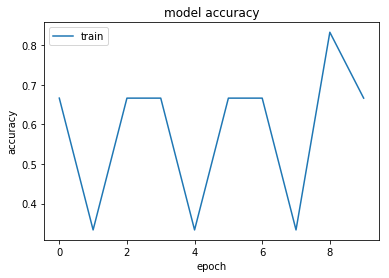

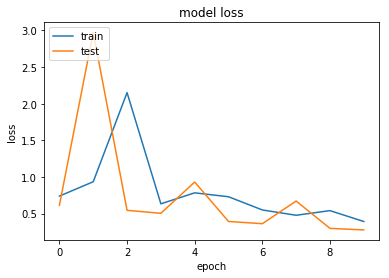

In [12]:
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [13]:
model.predict(X_test[:])

array([[0.9548341 , 0.0451659 ],
       [0.9554636 , 0.04453642],
       [0.9573894 , 0.04261056],
       [0.5060974 , 0.49390262],
       [0.54036623, 0.45963374],
       [0.9612563 , 0.03874364]], dtype=float32)

In [14]:
y_test[:]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.]], dtype=float32)